In [1]:
# %pip install --upgrade pip
# %pip install pandas
# %pip install google-api-python-client google-auth-httplib2 google-auth-oauthlib
# %pip install pyheif
# %pip install pillow_heif
# %pip install whatimage
# %pip install numpy
# %pip install matplotlib
# %pip install opencv-python
# %pip install scikit-image
# %pip install imutils


# Importing required libraries
import os
import pandas as pd
from googleapiclient.discovery import build
from google.oauth2 import service_account

import io

import pillow_heif
from PIL import Image

import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
from skimage.filters import threshold_local


# Troubleshooting OpenCV Library Issues in macOS

When encountering `ImportError: dlopen: library not loaded` errors while using OpenCV on macOS, follow these steps to resolve missing dynamic library issues (e.g., `libvmaf` or `libjxl`).

## Steps to Resolve Missing Dynamic Libraries

#### 1. **Install Missing Libraries**

Ensure that the missing libraries (`libvmaf`, `libjxl`, etc.) are installed using Homebrew.

```bash
# Install libvmaf
brew install libvmaf

# Install jpeg-xl (provides libjxl)
brew install jpeg-xl
```

#### 2. Verify Installation
Check that the expected libraries are present in the installation directory.

```bash

# Verify libvmaf
ls /usr/local/opt/libvmaf/lib/

# Verify libjxl
ls /usr/local/opt/jpeg-xl/lib/
```

#### 3. Create Symbolic Links
If the library version is different from what is expected, create symbolic links to point to the installed version.

```bash

# Create symlink for libvmaf (if version mismatch)
sudo ln -s /usr/local/opt/libvmaf/lib/libvmaf.3.dylib /usr/local/opt/libvmaf/lib/libvmaf.1.dylib

# Create symlink for libjxl (if version mismatch)
sudo ln -s /usr/local/opt/jpeg-xl/lib/libjxl.0.10.2.dylib /usr/local/opt/jpeg-xl/lib/libjxl.0.6.dylib
```

#### 4. Update DYLD_LIBRARY_PATH
Ensure that DYLD_LIBRARY_PATH includes the directories where the dynamic libraries are located.


For Intel-based macOS:

```bash

export DYLD_LIBRARY_PATH=/usr/local/opt/libvmaf/lib:/usr/local/opt/jpeg-xl/lib:$DYLD_LIBRARY_PATH
```

For Apple Silicon (M1/M2):

```bash
export DYLD_LIBRARY_PATH=/opt/homebrew/opt/libvmaf/lib:/opt/homebrew/opt/jpeg-xl/lib:$DYLD_LIBRARY_PATH
```

Add to .zshrc or .bash_profile to make persistent:

For zsh:

```bash

# Intel-based
echo 'export DYLD_LIBRARY_PATH=/usr/local/opt/libvmaf/lib:/usr/local/opt/jpeg-xl/lib:$DYLD_LIBRARY_PATH' >> ~/.zshrc
source ~/.zshrc

# Apple Silicon
echo 'export DYLD_LIBRARY_PATH=/opt/homebrew/opt/libvmaf/lib:/opt/homebrew/opt/jpeg-xl/lib:$DYLD_LIBRARY_PATH' >> ~/.zshrc
source ~/.zshrc
```

For bash:

```bash

# Intel-based
echo 'export DYLD_LIBRARY_PATH=/usr/local/opt/libvmaf/lib:/usr/local/opt/jpeg-xl/lib:$DYLD_LIBRARY_PATH' >> ~/.bash_profile
source ~/.bash_profile

# Apple Silicon
echo 'export DYLD_LIBRARY_PATH=/opt/homebrew/opt/libvmaf/lib:/opt/homebrew/opt/jpeg-xl/lib:$DYLD_LIBRARY_PATH' >> ~/.bash_profile
source ~/.bash_profile
```

#### 5. Reinstall FFmpeg
Reinstall ffmpeg to ensure it correctly links against the installed libraries.

```bash

brew reinstall ffmpeg
```

#### 6. Reinstall OpenCV
If OpenCV still doesn’t work, reinstall it to ensure it uses the correct dependencies.

```bash

pip uninstall opencv-python
pip install opencv-python
```


## References

- [Connecting to GDrive](https://medium.com/the-team-of-future-learning/integrating-google-drive-api-with-python-a-step-by-step-guide-7811fcd16c44)
- Cropping images ([1](https://www.kaggle.com/code/dmitryyemelyanov/receipt-ocr-part-1-image-segmentation-by-opencv),[2](https://pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/))

In [2]:
# Read 
gdrive_key_path = './keys/receipts-scan-c2ad26cb8ba1.json'

creds = service_account.Credentials.from_service_account_file(
  gdrive_key_path,
  scopes=['https://www.googleapis.com/auth/drive']
)

drive_service = build('drive', 'v3', credentials=creds)


In [3]:
results = drive_service.files().list().execute()

for file in results['files']:
  if 'mimeType' in file and file['mimeType'] == 'application/vnd.google-apps.folder':
    print(f"{file['name']} - {file['id']} is a {file['mimeType']}")

San Sai Safehouse - 1T-DJrMBxCfvN0_LgUbS44ONCmPEH2tJd is a application/vnd.google-apps.folder
Raw - 1OsJEiaH9n4FKrNMgPxxbZMYJArmiACPW is a application/vnd.google-apps.folder
2024-04 - 1x__4CUGWi853jdd7esjaj9VI4D8bIhO8 is a application/vnd.google-apps.folder
Raw - 1m6QplyEnzxLDhYwFwgMr2u1w_7yQMc0T is a application/vnd.google-apps.folder
2024-06 - 1vWW5LJSytNzHaiM8p_1H2JASzK9DYtcW is a application/vnd.google-apps.folder
Raw - 1D4ssqFeaxYqOgPTB62NXqJ5310Xxs04p is a application/vnd.google-apps.folder
2024-05 - 1bEbcRkBfCtsPCrOnnjRYCPkHEhmZAzEa is a application/vnd.google-apps.folder
Receipts - 1xt0ITdCmqIATy5YcYNZdU5xXOW1qHUoH is a application/vnd.google-apps.folder
Photos - 1M0i-NECH5rflf125wzC20FpbaK1wxyhc is a application/vnd.google-apps.folder


In [4]:
def get_root_folder_id():
  results = drive_service.files().list(q="name='Receipts'").execute()
  return results['files'][0]['id']

In [5]:
receipts_folder_id = get_root_folder_id()

In [6]:
def get_folder_id(service, parent_folder_id, folder_name):
  query = f"'{parent_folder_id}' in parents and mimeType = 'application/vnd.google-apps.folder' and name = '{folder_name}'"
  results = service.files().list(
    q=query,
    fields="files(id, name, mimeType)").execute()

  items = results.get('files', [])

  if not items:
    print(f'No subfolder named "{folder_name}" found.')
    return None
  else:
    return items[0]['id']

In [7]:
def list_files_in_folder(service, folder_id, sequence):
  query = f"'{folder_id}' in parents"
  results = service.files().list(
    q=query,
    fields="files(id, name, mimeType)").execute()

  items = results.get('files', [])

  if not items:
    print(f'No files found in folder ID {folder_id}.')
  else:
    print('Files:')
    for item in items:
      print(f'{item["name"]} ({item["id"]}) of type {item["mimeType"]}')
      item['folder_id'] = folder_id
      item['folder_path'] = '/'.join(sequence) + '/'
  return [item for item in items if 'image' in item['mimeType']]
            

In [8]:
def get_images(subfolder_names):

  images = []

  for sequence in subfolder_names:
    sequence_index = 0
    subfolder_id = ''
    # Recursively get the ID of the last subfolder in the list
    while sequence_index < len(sequence):
      if sequence_index == 0:
        subfolder_id = get_folder_id(drive_service, receipts_folder_id, sequence[sequence_index])
      if sequence_index > 0:
        subfolder_id = get_folder_id(drive_service, subfolder_id, sequence[sequence_index])

      if subfolder_id:
        print(f'Listing files in subfolder "{sequence[sequence_index]}":')
        new_images = list_files_in_folder(drive_service, subfolder_id, sequence[:sequence_index+1])
        images.extend(new_images)
        print()

      sequence_index += 1

  return pd.DataFrame(images)

In [9]:
subfolder_names = [['2024-04','Raw'],['2024-05','Raw'],['2024-06','Raw']]

get_images(subfolder_names)

Listing files in subfolder "2024-04":
Files:
Raw (1OsJEiaH9n4FKrNMgPxxbZMYJArmiACPW) of type application/vnd.google-apps.folder

Listing files in subfolder "Raw":
Files:
signal-2024-06-08-092346_008.jpeg (1oIUIbASr5fhSWpINFFSLZgHwhcmBcDId) of type image/jpeg
signal-2024-06-08-092346_007.jpeg (1OyhXEFNliSbB47a8Jqs4Iy_LpS0Eyu39) of type image/jpeg
signal-2024-06-08-092346_006.jpeg (1l1wAd71gI1yR6TEj8Z3ClVC_RSJ8c-DV) of type image/jpeg
signal-2024-06-08-092346_005.jpeg (1XcDQ4nf5vXsWXASI0I6bwP0g74nP_0sC) of type image/jpeg
IMG_7039.HEIC (1lO5x2KuCRmWnHvYZbQyhOwXb3nyFnlPa) of type image/heif
IMG_7038.heic (19lJHqDL7yE4Fq7hSBvF3BljITDYBuyj4) of type image/heif
IMG_7029.HEIC (1qC_iE7Qct3bV_eX3P9XyIrqu1osa4DC1) of type image/heif
IMG_7037.HEIC (1bBGTpo1NMuHFfgsYe-lCuP1qM37RKXzU) of type image/heif
IMG_7036.HEIC (1X2DMKIdGvple35lyNDTimGlB1LweQOsb) of type image/heif
IMG_7035.HEIC (12ESmFuLouOCmqulYvq0li9bMr0OGaObP) of type image/heif
IMG_7034.HEIC (1kFAKmPt1a3tBsyDuubcp6sZ6AZt1NXhC) of type im

,mimeType,id,name,folder_id,folder_path
0,image/jpeg,1oIUIbASr5fhSWpINFFSLZgHwhcmBcDId,signal-2024-06-08-092346_008.jpeg,1OsJEiaH9n4FKrNMgPxxbZMYJArmiACPW,2024-04/Raw/
1,image/jpeg,1OyhXEFNliSbB47a8Jqs4Iy_LpS0Eyu39,signal-2024-06-08-092346_007.jpeg,1OsJEiaH9n4FKrNMgPxxbZMYJArmiACPW,2024-04/Raw/
2,image/jpeg,1l1wAd71gI1yR6TEj8Z3ClVC_RSJ8c-DV,signal-2024-06-08-092346_006.jpeg,1OsJEiaH9n4FKrNMgPxxbZMYJArmiACPW,2024-04/Raw/
3,image/jpeg,1XcDQ4nf5vXsWXASI0I6bwP0g74nP_0sC,signal-2024-06-08-092346_005.jpeg,1OsJEiaH9n4FKrNMgPxxbZMYJArmiACPW,2024-04/Raw/
4,image/heif,1lO5x2KuCRmWnHvYZbQyhOwXb3nyFnlPa,IMG_7039.HEIC,1OsJEiaH9n4FKrNMgPxxbZMYJArmiACPW,2024-04/Raw/
5,image/heif,19lJHqDL7yE4Fq7hSBvF3BljITDYBuyj4,IMG_7038.heic,1OsJEiaH9n4FKrNMgPxxbZMYJArmiACPW,2024-04/Raw/
6,image/heif,1qC_iE7Qct3bV_eX3P9XyIrqu1osa4DC1,IMG_7029.HEIC,1OsJEiaH9n4FKrNMgPxxbZMYJArmiACPW,2024-04/Raw/
7,image/heif,1bBGTpo1NMuHFfgsYe-lCuP1qM37RKXzU,IMG_7037.HEIC,1OsJEiaH9n4FKrNMgPxxbZMYJArmiACPW,2024-04/Raw/
8,image/heif,1X2DMKIdGvple35lyNDTimGlB1LweQOsb,IMG_7036.HEIC,1OsJEiaH9n4FKrNMgPxxbZMYJArmiACPW,2024-04/Raw/
9,image/heif,12ESmFuLouOCmqulYvq0li9bMr0OGaObP,IMG_7035.HEIC,1OsJEiaH9n4FKrNMgPxxbZMYJArmiACPW,2024-04/Raw/


## Image Processing

In [10]:
def get_image(filename,mimeType):
  file = drive_service.files().get_media(fileId=filename).execute()
  if mimeType == 'image/jpeg':
    return Image.open(io.BytesIO(file))
  elif mimeType == 'image/heif':
    heif_file = pillow_heif.read_heif(file)
    image = Image.frombytes(
      heif_file.mode, 
      heif_file.size, 
      heif_file.data,
      "raw",
      heif_file.mode,
      heif_file.stride,
    )
    return image
  else:
    print(f"Unsupported image type: {mimeType}")
    return None


In [11]:
def detect_edges(image_arg):
  # Convert to NumPy array
  opencv_image = np.array(image_arg)

  # Convert RGB to BGR
  image = cv2.cvtColor(opencv_image, cv2.COLOR_RGB2BGR)
  # load the image and compute the ratio of the old height
  # to the new height, clone it, and resize it
  ratio = image.shape[0] / 500.0
  orig = image.copy()
  image = imutils.resize(image, height = 500)
  # convert the image to grayscale, blur it, and find edges
  # in the image
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (5, 5), 0)
  edged = cv2.Canny(gray, 75, 200)
  # show the original image and the edge detected image
  print("STEP 1: Edge Detection")
  return (edged,image)

In [12]:
image_raw = get_image('1thh5QDTLPwsSTQNtHA5LxlGKbW1F6FBd', 'image/heif')

STEP 1: Edge Detection


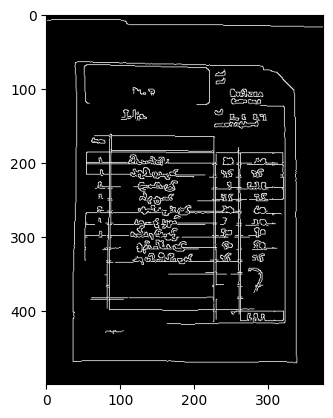

In [13]:
# display the image
(edged,image_resized) = detect_edges(image_raw)

plt.imshow(edged, cmap='gray')


In [33]:
def find_contours(edged,image_arg):
  image = np.array(image_arg)
  # find the contours in the edged image, keeping only the
  # largest ones, and initialize the screen contour
  cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
  # loop over the contours
  for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    if len(approx) == 4:
      screenCnt = approx
      break
  largest_contour = max(cnts, key=cv2.contourArea)

  # show the contour (outline) of the piece of paper
  print("STEP 2: Find contours of paper")
  contours = cv2.drawContours(image, [largest_contour], -1, (0, 255, 0), 2)
  # contours = cv2.drawContours(image, cnts, -1, (0, 255, 0), 2)


  # Get the bounding box of the largest contour
  x, y, w, h = cv2.boundingRect(largest_contour)

  # Crop the image using the bounding box
  cropped_image = image[y:y+h, x:x+w]
  cropped_image = cv2.cvtColor(largest_contour, cv2.COLOR_BGR2RGB)
  return cropped_image

STEP 2: Find contours of paper


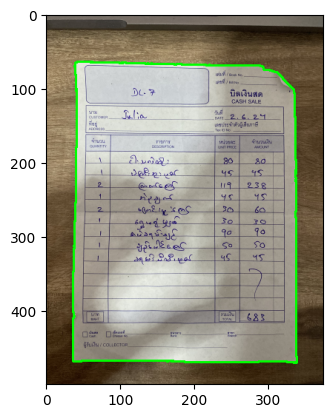

In [35]:
# show opencv image in jupyter notebook
cropped = find_contours(edged,image_resized)
plt.imshow(cropped)